### Make sure calibration_curve is actually doing what we want

In [43]:
import numpy as np
import scipy.stats

from calibration import calibration_curve

# first sample from a bunch of distributions
# and have the model output be various other distributions
rng = np.random.default_rng(seed=2022)

xgrid, ygrid = np.meshgrid(
    np.linspace(-6, 6, 120),
    np.linspace(-6, 6, 120)
)

uniform_samples = rng.uniform(size=(1000, 2))
# rescale to be on the square [-6, 6]^2
uniform_samples = (uniform_samples * 12) - 6

std_normal_samples = rng.normal(size=(1000, 2))
skewed_normal_samples = rng.multivariate_normal(
    mean=[0, 0],
    cov=[[2, -1], [-1, 2]],
    size=1000
)

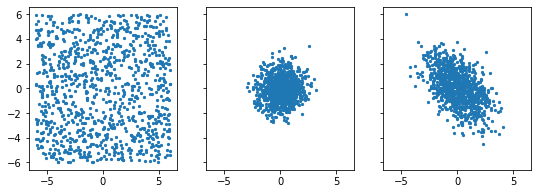

In [44]:
# display the distributions
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
axs[0].scatter(uniform_samples[:, 0], uniform_samples[:, 1], s=5)
axs[1].scatter(std_normal_samples[:, 0], std_normal_samples[:, 1], s=5)
axs[2].scatter(skewed_normal_samples[:, 0], skewed_normal_samples[:, 1], s=5)

In [67]:
n_gridpts = xgrid.shape[0] * xgrid.shape[1]
perfect_uniform_model = np.ones(xgrid.shape) * (1 / n_gridpts)

std_normal_model = scipy.stats.multivariate_normal(
    mean=[0,0], cov=1
    ).pdf(np.dstack((xgrid, ygrid)))

skewed_normal_model = scipy.stats.multivariate_normal(
    mean=[0,0], cov=[[2, -1], [-1, 2]]
    ).pdf(np.dstack((xgrid, ygrid)))

# and renormalize
std_normal_model /= std_normal_model.sum()
skewed_normal_model /= skewed_normal_model.sum()

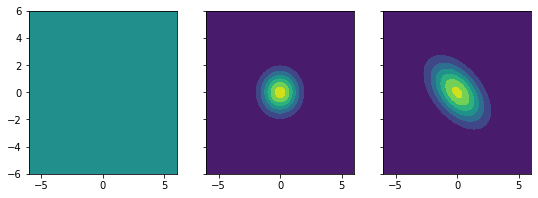

In [68]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
axs[0].contourf(xgrid, ygrid, perfect_uniform_model)
axs[1].contourf(xgrid, ygrid, std_normal_model)
axs[2].contourf(xgrid, ygrid, skewed_normal_model)
plt.show()

In [69]:
# repeat each model to represent model output across samples

def repeat(model_output, num_samples):
    return model_output[np.newaxis, :].repeat(num_samples, axis=0)

rep_uniform = repeat(perfect_uniform_model, 1000)
rep_std_normal = repeat(std_normal_model, 1000)
rep_skewed_normal = repeat(skewed_normal_model, 1000)

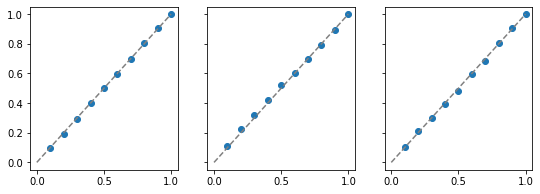

In [70]:
# we should expecty perfect calibration for each model for their respective
# distribution

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
calibration_curve(
    rep_uniform,
    uniform_samples,
    xgrid,
    ygrid,
    axs[0]
)
calibration_curve(
    rep_std_normal,
    std_normal_samples,
    xgrid,
    ygrid,
    axs[1]
)
calibration_curve(
    rep_skewed_normal,
    skewed_normal_samples,
    xgrid,
    ygrid,
    axs[2]
)

plt.show()

Great! Now compare everything versus uniform.

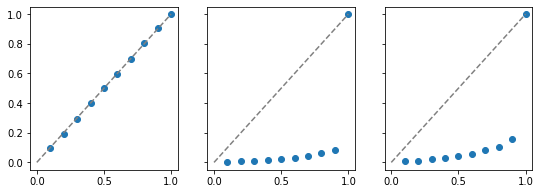

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
calibration_curve(
    rep_uniform,
    uniform_samples,
    xgrid,
    ygrid,
    axs[0]
)
calibration_curve(
    rep_std_normal,
    uniform_samples,
    xgrid,
    ygrid,
    axs[1]
)
calibration_curve(
    rep_skewed_normal,
    uniform_samples,
    xgrid,
    ygrid,
    axs[2]
)
plt.show()

Does this make sense? The observed proportion of samples in a given interval is far less than the expected. This makes sense given that the models are predicting various normal distributions but the data is actually drawn from a uniform distribution. Thus the models are overconfident.

Now check everything versus standard normal.

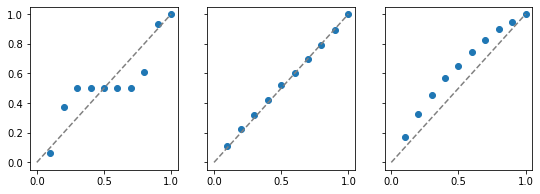

In [72]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
calibration_curve(
    rep_uniform,
    std_normal_samples,
    xgrid,
    ygrid,
    axs[0]
)
calibration_curve(
    rep_std_normal,
    std_normal_samples,
    xgrid,
    ygrid,
    axs[1]
)
calibration_curve(
    rep_skewed_normal,
    std_normal_samples,
    xgrid,
    ygrid,
    axs[2]
)
plt.show()

And now versus the skewed normal.

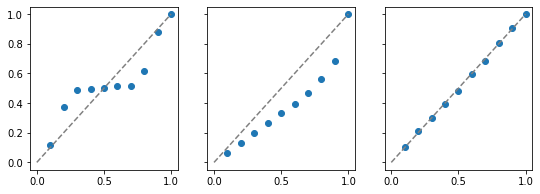

In [73]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
calibration_curve(
    rep_uniform,
    skewed_normal_samples,
    xgrid,
    ygrid,
    axs[0]
)
calibration_curve(
    rep_std_normal,
    skewed_normal_samples,
    xgrid,
    ygrid,
    axs[1]
)
calibration_curve(
    rep_skewed_normal,
    skewed_normal_samples,
    xgrid,
    ygrid,
    axs[2]
)
plt.show()

Now check what smaller amounts of data do to these plots.

In [77]:
fewer_uniform = rng.choice(uniform_samples, size=100)
fewer_std_norm = rng.choice(std_normal_samples, size=100)
fewer_skew_norm = rng.choice(skewed_normal_samples, size=100)

fewer_uniform_model = repeat(perfect_uniform_model, 100)
fewer_std_norm_model = repeat(std_normal_model, 100)
fewer_skew_norm_model = repeat(skewed_normal_model, 100)

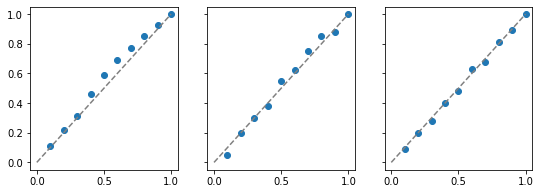

In [78]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
calibration_curve(
    fewer_uniform_model,
    fewer_uniform,
    xgrid,
    ygrid,
    axs[0]
)
calibration_curve(
    fewer_std_norm_model,
    fewer_std_norm,
    xgrid,
    ygrid,
    axs[1]
)
calibration_curve(
    fewer_skew_norm_model,
    fewer_skew_norm,
    xgrid,
    ygrid,
    axs[2]
)

plt.show()

And now a mix of outputs: half uniform and half std normal, for pure normal observed data.

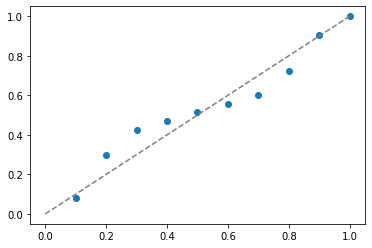

In [83]:
mixed = lambda num_samples: np.concatenate(
    (repeat(perfect_uniform_model, int(num_samples/2)),
    repeat(std_normal_model, num_samples - int(num_samples/2)))
)

calibration_curve(
    mixed(1000),
    std_normal_samples,
    xgrid,
    ygrid
)
plt.show()

And now with less data.

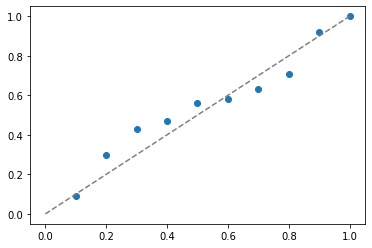

In [84]:
calibration_curve(
    mixed(100),
    fewer_std_norm,
    xgrid,
    ygrid
)
plt.show()